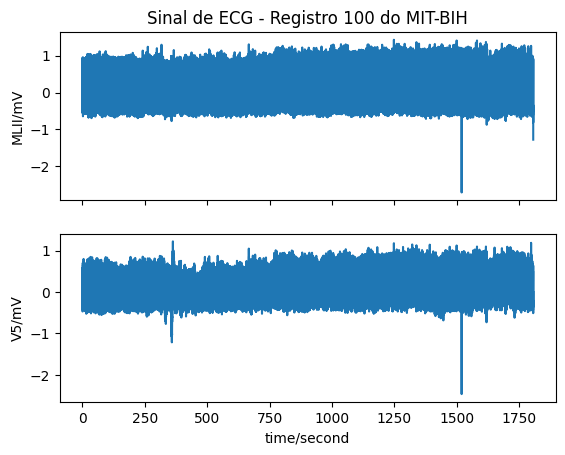

In [2]:
# Importando as bibliotecas necessárias
import wfdb
import matplotlib.pyplot as plt
import numpy as np

# Baixando e carregando um registro (record) do PhysioNet
#'100' é o nome do registro que queremos
# pn_dir'mitdb' informa á biblioteca para procura no MIT-BIH Arrhythmia Database
record = wfdb.rdrecord('100', pn_dir='mitdb')

# A biblioteca wfdb tem uma função de plotagem própria para uma visualização rápida
wfdb.plot_wfdb(record=record, title='Sinal de ECG - Registro 100 do MIT-BIH')

# Exibe o gráfico
plt.show()

In [3]:
# Vamos explorar o objeto 'record' que carregamos
# Frequência de amostragem (samples per second)
fs = record.fs
# Nomes dos sinais (as duas derivações)
sig_names = record.sig_name
# O sinal em si, como um array do Numpy
sinal = record.p_signal
# Unidades do sinal
units = record.units
# Comentários contidos no arquivo
comments = record.comments

print(f"Frequência de Amostragem (fs): {fs} Hz")
print(f"Nomes dos Sinais: {sig_names}")
print(f"Shape do array do sinal: {sinal.shape}")
print(f"Unidades: {units}")
print("\nComentários no arquivo:")
for comment in comments:
    print(f"- {comment}")

Frequência de Amostragem (fs): 360 Hz
Nomes dos Sinais: ['MLII', 'V5']
Shape do array do sinal: (650000, 2)
Unidades: ['mV', 'mV']

Comentários no arquivo:
- 69 M 1085 1629 x1
- Aldomet, Inderal


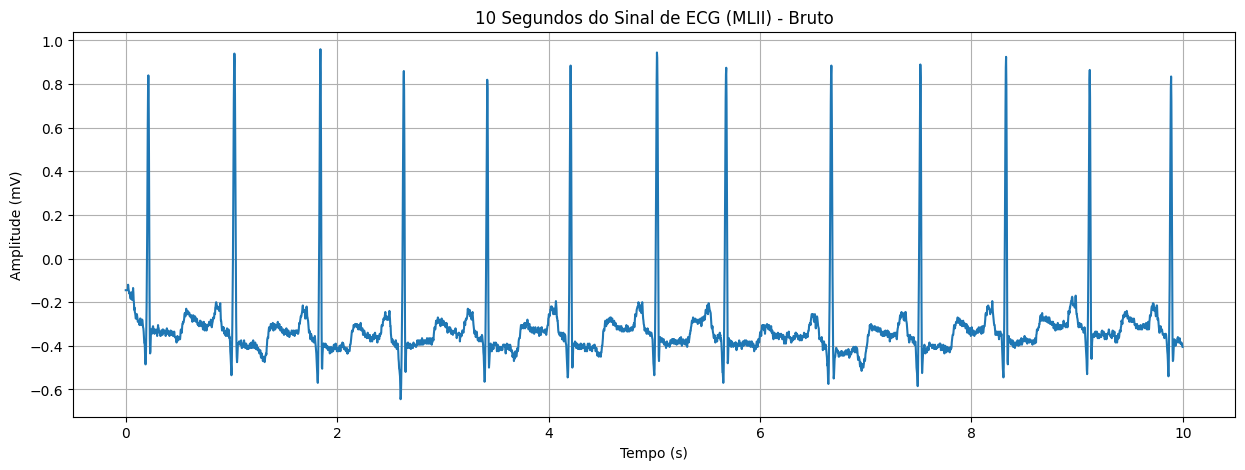

In [4]:
# Vamos trabalhar apenas com o primeiro sinal (MLII)
sinal_mlii = sinal[:, 0]

# Criar um vetor de tempo para o eixo X
# Vamos pegar os primeiros 10 segundos de dados
num_amostras = 10 * fs  # 10 segundos * 360 amostras/segundo
tempo = np.arange(num_amostras) / fs

# Configurar o plot com Matplotlib para ter mais controle
plt.figure(figsize=(15, 5)) # Define o tamanho do gráfico
plt.plot(tempo, sinal_mlii[:num_amostras])
plt.title('10 Segundos do Sinal de ECG (MLII) - Bruto')
plt.xlabel('Tempo (s)')
plt.ylabel(f'Amplitude ({units[0]})')
plt.grid(True) # Adiciona uma grade para facilitar a visualização
plt.show()

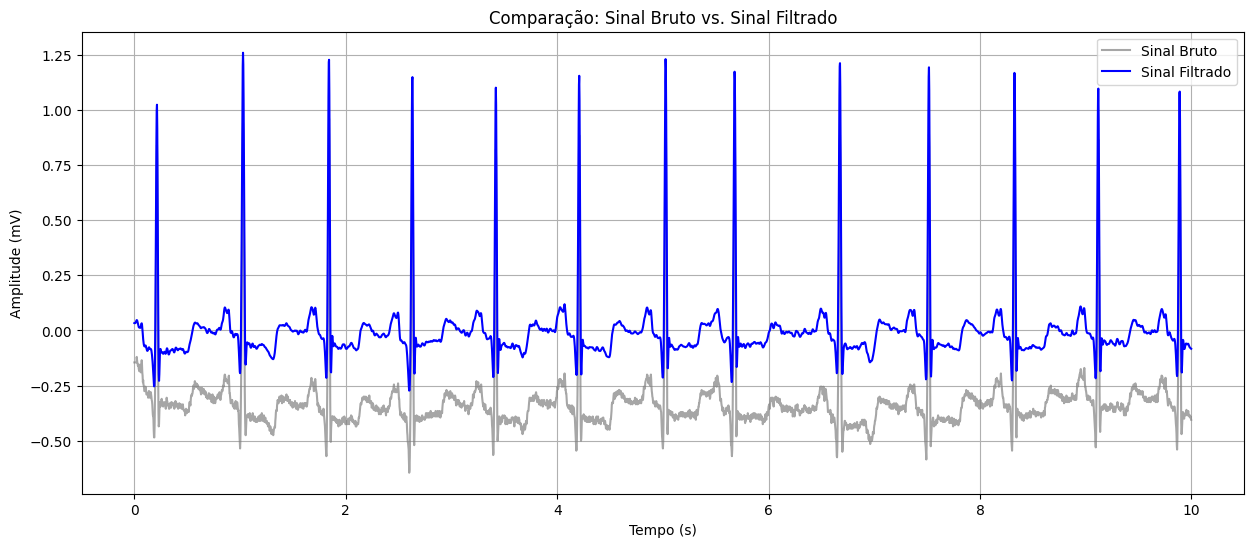

In [5]:
from scipy.signal import butter, filtfilt

# --- Configurações do Filtro Passa-Faixa ---
lowcut = 0.5   # Frequência de corte inferior (Hz)
highcut = 45.0 # Frequência de corte superior (Hz)
order = 4      # Ordem do filtro (controla a "agressividade" do corte)

# 1. Projetar o filtro: Obter os coeficientes do filtro
#    A função 'butter' projeta um filtro Butterworth digital.
nyquist = 0.5 * fs # Frequência de Nyquist (metade da amostragem)
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(order, [low, high], btype='band')

# 2. Aplicar o filtro ao nosso sinal (sinal_mlii)
#    Usamos 'filtfilt' em vez de 'lfilter' para evitar atrasos de fase.
#    Em palavras simples: os picos no sinal filtrado continuarão no mesmo lugar.
sinal_filtrado = filtfilt(b, a, sinal_mlii)


# --- Visualizar o Antes e Depois ---
plt.figure(figsize=(15, 6))
# Plota o sinal bruto (os mesmos 10 segundos de antes)
plt.plot(tempo, sinal_mlii[:num_amostras], label='Sinal Bruto', color='gray', alpha=0.7)
# Plota o sinal filtrado por cima
plt.plot(tempo, sinal_filtrado[:num_amostras], label='Sinal Filtrado', color='blue')

plt.title('Comparação: Sinal Bruto vs. Sinal Filtrado')
plt.xlabel('Tempo (s)')
plt.ylabel(f'Amplitude ({units[0]})')
plt.legend() # Mostra a legenda (Bruto vs. Filtrado)
plt.grid(True)
plt.show()

Altura mínima calculada: 0.76
Picos R encontrados (índices): [  77  370  663  947 1231 1515 1809 2044 2403 2706 2997 3283 3560]
Total de 13 batimentos detectados nos primeiros 10 segundos.


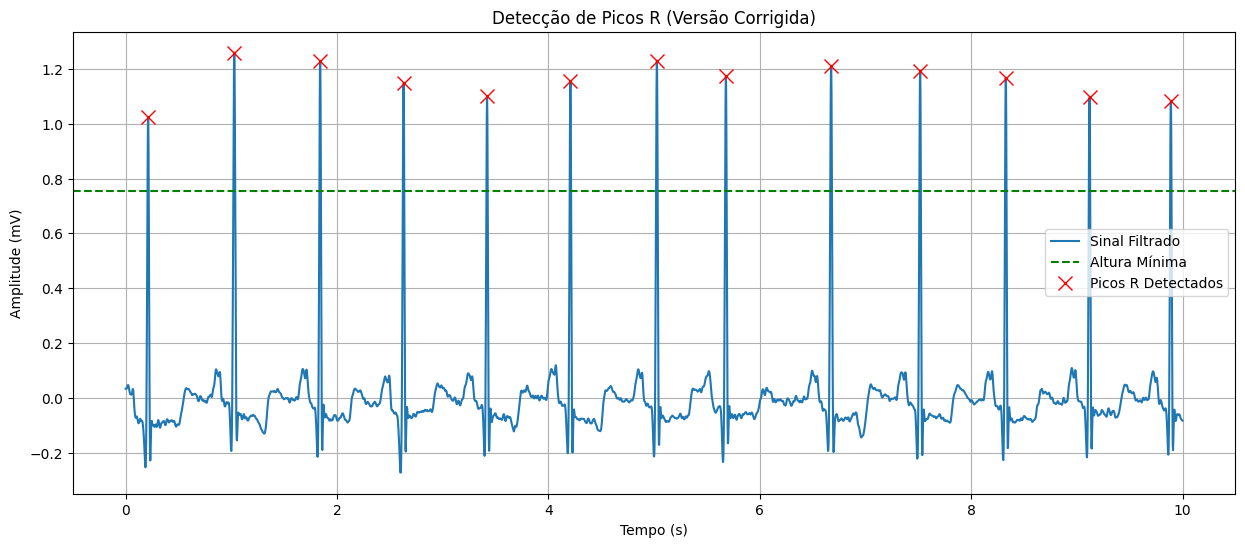

In [9]:
# --- Versão Corrigida da Detecção de Picos ---

# Vamos focar apenas no nosso trecho de 10 segundos para definir a altura
trecho_sinal = sinal_filtrado[:num_amostras]

# Regra 1: Altura mínima do pico (agora baseada apenas no nosso trecho)
altura_minima_corrigida = 0.6 * np.max(trecho_sinal)

# Regra 2: Distância mínima (a mesma de antes, que é uma regra fisiológica)
distancia_minima = int(fs / 3.33) 

# Imprimir o valor calculado para depuração
print(f"Altura mínima calculada: {altura_minima_corrigida:.2f}")

# Usando a função find_peaks com a nova altura
picos_r, _ = find_peaks(trecho_sinal, height=altura_minima_corrigida, distance=distancia_minima)

print(f"Picos R encontrados (índices): {picos_r}")
print(f"Total de {len(picos_r)} batimentos detectados nos primeiros 10 segundos.")


# --- Visualizar os picos detectados ---
plt.figure(figsize=(15, 6))

# Plotar o trecho do sinal filtrado
plt.plot(tempo, trecho_sinal, label='Sinal Filtrado')

# Adicionar uma linha para visualizar nossa altura mínima
plt.axhline(y=altura_minima_corrigida, color='g', linestyle='--', label='Altura Mínima')

# Plotar os picos R encontrados com um marcador vermelho 'x'
plt.plot(picos_r / fs, trecho_sinal[picos_r], "x", markersize=10, color='red', label='Picos R Detectados')

plt.title('Detecção de Picos R (Versão Corrigida)')
plt.xlabel('Tempo (s)')
plt.ylabel(f'Amplitude ({units[0]})')
plt.legend()
plt.grid(True)
plt.show()

--- Análise da Frequência Cardíaca ---
Intervalos RR (em segundos): ['0.81', '0.81', '0.79', '0.79', '0.79', '0.82', '0.65', '1.00', '0.84', '0.81', '0.79', '0.77']
BPM para cada intervalo: ['73.7', '73.7', '76.1', '76.1', '76.1', '73.5', '91.9', '60.2', '71.3', '74.2', '75.5', '78.0']

-----------------------------------------
BPM Médio: 75.0 batimentos por minuto
-----------------------------------------


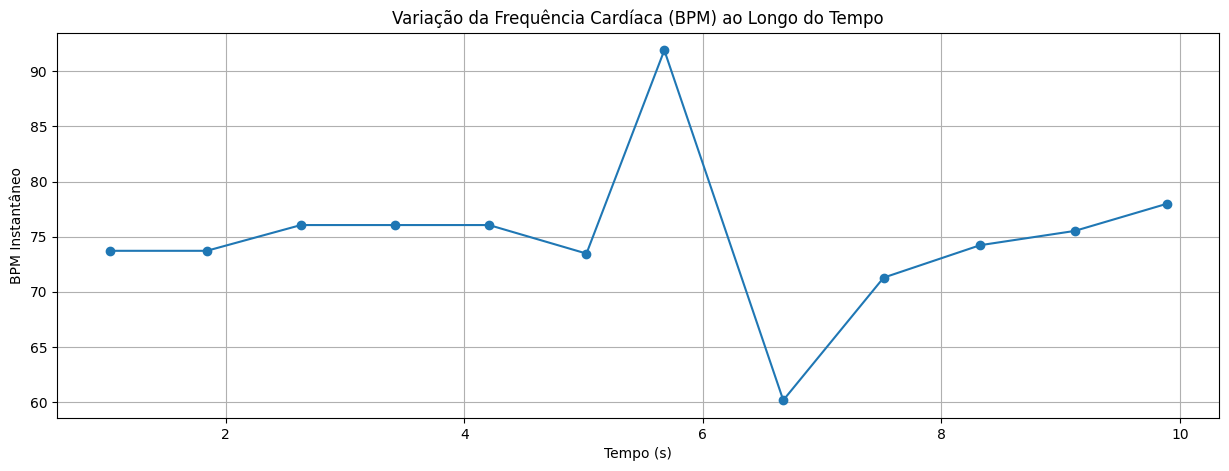

In [10]:
# Verificamos se temos pelo menos dois picos para calcular um intervalo
if len(picos_r) > 1:
    # 1. Calcular os intervalos RR em número de amostras
    intervalos_rr_amostras = np.diff(picos_r)
    
    # 2. Converter os intervalos para segundos
    intervalos_rr_segundos = intervalos_rr_amostras / fs
    
    # 3. Converter os intervalos em segundos para BPM
    bpm_instantaneo = 60 / intervalos_rr_segundos
    
    # Calcular o BPM médio
    bpm_medio = np.mean(bpm_instantaneo)
    
    print("--- Análise da Frequência Cardíaca ---")
    print(f"Intervalos RR (em segundos): {[f'{x:.2f}' for x in intervalos_rr_segundos]}")
    print(f"BPM para cada intervalo: {[f'{x:.1f}' for x in bpm_instantaneo]}")
    print("\n-----------------------------------------")
    print(f"BPM Médio: {bpm_medio:.1f} batimentos por minuto")
    print("-----------------------------------------")

    # Visualizar a variação do BPM ao longo do tempo
    plt.figure(figsize=(15, 5))
    plt.plot(picos_r[1:] / fs, bpm_instantaneo, marker='o', linestyle='-')
    plt.title('Variação da Frequência Cardíaca (BPM) ao Longo do Tempo')
    plt.xlabel('Tempo (s)')
    plt.ylabel('BPM Instantâneo')
    plt.grid(True)
    plt.show()

else:
    print("Não foram encontrados picos suficientes para calcular o BPM.")